# Solución de la ecuación de onda en 2D por el método de diferencias finitas

Este notebook implementa la solución numérica de la ecuación de onda en dos dimensiones utilizando el método de diferencias finitas. Además, se generan sismogramas sintéticos que serán utilizados posteriormente para entrenar una red neuronal física informada (PINN).

## Contenido:
1. Implementación del solver de diferencias finitas
2. Configuración del problema y ejecución del solver
3. Visualización de resultados
4. Generación y almacenamiento de sismogramas sintéticos
5. Carga y visualización de sismogramas

Este notebook es parte de un proyecto más amplio que busca comparar los resultados obtenidos mediante diferencias finitas con los de una PINN para la inversión de datos sísmicos.

## Contexto:
La ecuación de onda en dos dimensiones es:
<center> $\frac{\partial^2 u}{\partial t^2}=v^2 \left( \frac{\partial ^2 u}{\partial x^2} + \frac{\partial ^2 u}{\partial y^2} \right) $,     $t>0$, $0 < x < L_x$, $0 < y < L_y$ </center>

La solución en una dimensión es una función del tipo f(x-vt) o g(x+vt). A diferecia de la ecuación de calor que es parabólica, la ecuación de onda es hiperbólica.

Las condiciones de frontera de Dirichlet iguales a cero implican una frontera fija y que la onda se refleja invertida. Las condiciones de frontera de Neumann implican una frontera libre y que la onda se refleja sin invertirse.

Para resolverla se utilizan diferencias centradas en tiempo y en espacio. Se utiliza el siguiente esquema:
<center> $\frac{u^{n+1}_{i,j} − 2u^{n}_{i,j} + u^{n−1}_{i,j}}{\Delta t ^2} = c^2\left(\frac{u^{n}_{i+1,j} − 2u^{n}_{i,j} + u^{n}_{i−1,j}}{\Delta x^2} + \frac{u^{n}_{i,j+1} − 2u^{n}_{i,j} + u^{n}_{i,j-1}}{\Delta y^2}\right)$ <center>

De ahí se despeja $u^{n+1}_{i,j}$

In [1]:
# Importamos las paqueterias utilizadas para el solver.
import time
import numpy as np
# Y las paqueterías utilizadas para graficar y animar.
import matplotlib.pylab as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"

## Implementación del solver de diferencias finitas

La siguiente función `EcOnda_Solver` implementa el método de diferencias finitas para resolver la ecuación de onda en 2D. Los parámetros de entrada son:

- `I`: Función de la condición inicial para el desplazamiento
- `V`: Función de la condición inicial para la velocidad
- `f`: Función del forzamiento (opcional)
- `C`: Campo de velocidades (matriz)
- `Lx`, `Ly`: Dimensiones del dominio
- `Nx`, `Ny`: Número de puntos de la malla en cada dirección
- `dt`: Paso de tiempo
- `T`: Tiempo total en el que se obtiene la solución
- `CF`: Tipo de condiciones de frontera ('D' para Dirichlet, 'N' para Neumann, 'A' para absorbentes, 'S' para simular las del subsuelo)

Las condiciones de frontera que simulan el subsuelo son fronteras absorbentes en x=0, x=Lx y en z=Ly, y una frontera libre en la superficie.

La función devuelve las coordenadas espaciales, el vector de tiempo y la solución completa.

In [2]:
def EcOnda_Solver(I, V, f, C, Lx, Ly, Nx, Ny, dt, T, CF):
    t0 = time.time() # Inicia contador
    
    """
         .+------+
       .' |    .'|
      +---+--+'  |
      |   |  |   |
    u |  ,+--+---+
      |.'    | .' y
      +------+'
         x
    """
    
    # Dominio espacial
    x = np.linspace(0, Lx, Nx+1)  # Puntos de malla en x
    y = np.linspace(0, Ly, Ny+1)  # Puntos de malla en y
    xv = x[:,np.newaxis]          # Añadimos otra dimensión a los vectores
    yv = y[np.newaxis,:]

    # Dominio temporal
    Nt = int(round(T/float(dt)))  # Puntos de malla en tiempo
    t = np.arange(0,T+dt,dt)

    # Calculamos los tamaños de pasos dx, dy 
    dx = float(Lx/Nx)
    dy = float(Ly/Ny)
    # Se calculan variables auxiliares
    Cx2 = (C*dt/dx)**2;  Cy2 = (C*dt/dy)**2    
    dt2 = dt**2

    # Forzamiento
    if f is None or f == 0:
        f = lambda x, y, t: np.zeros((x.shape[0], y.shape[1]))
    # Condiciones iniciales de velocidad V 
    if V is None or V == 0:
        V = lambda x, y: np.zeros((x.shape[0], y.shape[1]))
    # Condiciones iniciales de posición I
    if I is None or I == 0:
        I = lambda x, y: np.zeros((x.shape[0], y.shape[1]))

    # Preasignamos matrices para la solución
    u     = np.zeros((Nx+1,Ny+1))    # Solución
    u_n   = np.zeros((Nx+1,Ny+1))    # Solución en t-dt
    u_nm1 = np.zeros((Nx+1,Ny+1))    # Solución en t-2*dt
    f_a   = np.zeros((Nx+1,Ny+1))    # Forzamiento
    sol   = np.zeros((Nx+1,Ny+1,Nt)) # Arreglo 3D para almacenar u

    # Índices
    It = list(range(0, t.shape[0]))

    # Se aplican las condiciones iniciales
    u_n[:,:] = I(xv, yv)

    # Primer paso de tiempo
    n = 0
    f_a[:,:] = f(xv, yv, t[n])  # Forzamiento
    V_a = V(xv, yv)             # Velocidad inicial
    u = Esquema(u, u_n, u_nm1, f_a, dx, dt, C, Cx2, Cy2, dt2, CF, Nx, Nz, V=V_a, paso1=True)
    # Reescribimos las matrices para el siguiente paso
    u_nm1, u_n, u = u_n, u, u_nm1

    # Resolvemos para los siguientes pasos de tiempo
    for n in It[1:-1]:
        f_a[:,:] = f(xv, yv, t[n])
        u = Esquema(u, u_n, u_nm1, f_a, dx, dt, C, Cx2, Cy2, dt2, CF, Nx, Nz)
        sol[:,:,n] = u
        u_nm1, u_n, u = u_n, u, u_nm1
        
    t1 = time.time()
    elps = t1 - t0
    print("> Tiempo (s):", elps)
        
    return x, y, t, sol

# Se define una función para aplicar el esquema de diferencias centradas
def Esquema(u, u_n, u_nm1, f_a, dx, dt, C, Cx2, Cy2, dt2, CF, Nx, Ny, V=None, paso1=False):
    if paso1:
        dt = np.sqrt(dt2)
        Cx2 = 0.5*Cx2;  Cy2 = 0.5*Cy2; dt2 = 0.5*dt2  # Se redefinen las variables auxiliares
        D1 = 1;  D2 = 0
    else:
        D1 = 2;  D2 = 1

    u_xx = u_n[:-2,1:-1] - 2*u_n[1:-1,1:-1] + u_n[2:,1:-1]
    u_yy = u_n[1:-1,:-2] - 2*u_n[1:-1,1:-1] + u_n[1:-1,2:]

    u[1:-1,1:-1] = D1*u_n[1:-1,1:-1] - D2*u_nm1[1:-1,1:-1] + \
        Cx2[1:-1,1:-1]*u_xx + Cy2[1:-1,1:-1]*u_yy + dt2*f_a[1:-1,1:-1]

    if paso1:
        u[1:-1,1:-1] += dt*V[1:-1, 1:-1] # Se aplica la velocidad inicial
    
    # Aplicamos condiciones de frontera
    if CF=='D': # Dirichlet
        u[0,:] = 0
        u[:,0] = 0
        u[-1,:]= 0
        u[:,-1]= 0

    if CF=='N': # Neumann
        u[0,:] = u_n[0,:]+2*Cx2[0,:]*(u_n[1,:]-u_n[0,:])
        u[-1,:] = u_n[-1,:]+2*Cy2[-1,:]*(u_n[-2,:]-u_n[-1,:])
        u[:,0] = u_n[:,0]+2*Cx2[:,0]*(u_n[:,1]-u_n[:,0])
        u[:,-1] = u_n[:,-1]+2*Cy2[:,-1]*(u_n[:,-2]-u_n[:,-1])
        
    if CF=='A': # Absorbentes de primer orden ABC
        # Fronteras izquierda y derecha
        for j in range(Ny):
            c=C[0,j]
            u[0, j] = u_n[1, j] + (c * dt / dx) * (u_n[0, j] - u[1, j])
            c=C[-1,j]
            u[-1, j] = u_n[-2, j] + (c * dt / dx) * (u_n[-1, j] - u_n[-2, j])
    
        # Fronteras superior e inferior
        for i in range(Nx):
            c=C[i,0]
            u[i, 0] = u_n[i, 1] + (c * dt / dx) * (u_n[i, 0] - u_n[i, 1])
            c=C[i,-1]
            u[i, -1] = u_n[i, -2] + (c * dt / dx) * (u_n[i, -1] - u_n[i, -2])
            
    if CF=='S': # Condiciones de frontera que simulan el subsuelo, todas absorbentes excepto la frontera superior, que es libre
        # Fronteras superior e inferior
        for i in range(Nx):
            u[:,0] = u_n[:,0]+2*Cx2[:,0]*(u_n[:,1]-u_n[:,0])
            c=C[i,-1]
            u[i, -1] = u_n[i, -2] + (c * dt / dx) * (u_n[i, -1] - u_n[i, -2])
            
        # Fronteras izquierda y derecha
        for j in range(Ny):
            c=C[0,j]
            u[0, j] = u_n[1, j] + (c * dt / dx) * (u_n[0, j] - u[1, j])
            c=C[-1,j]
            u[-1, j] = u_n[-2, j] + (c * dt / dx) * (u_n[-1, j] - u_n[-2, j])

    return u

## Configuración del problema

Aquí definimos los parámetros específicos para nuestra simulación:

- Dimensiones del dominio espacial: 1 km x 1 km
- Tiempo total en el que se calcula la solución: 6 segundos
- Paso de tiempo: 0.012 segundos
- Resolución de la malla: 81 x 81 puntos

La condición inicial es un pulso gaussiano en el centro del dominio. El campo de velocidades es homogéneo con v = 0.5 km/s, pero se incluyen comentarios para implementar campos de velocidad en capas o con barreras físicas.

Las condiciones de frontera simulan el subsuelo: todas las fronteras son absorbentes excepto la superior, que es libre (Neumann).

In [3]:
# Dimensiones
Lx = 1
Lz = 1
T = 6 # Tiempo total
dt = 0.012

# Pasos
Nx = 81        # Pasos en x
Nz = 81        # Pasos en y

# Condición inicial de pulso gaussiano
def I(x,z):
    return np.exp(-60*((x-Lx/2)**2+(z-Lz/2)**2))

# Velocidad homogénea
v=0.5
C=np.ones((Nx+1,Nz+1))*v

######################################
# Velocidad en capas
#a=8   # Profundidad
#v1=1.5
#v2=3

def VelCapa(a, Nx, Nz, v1, v2):
    s=a*Nz/Lz
    j1=int(s)
    C=np.ones((Nx+1,Nz+1))*v1
    C[:-j1,:]=v2; # C[x][z]
    return C

#C=VelCapa(a,Nx,Nz,v1,v2)

# Barrera física cuadrada en el centro
def VelCuadrado(Nx, Nz, xi, zi, l1, l2, v1, v2):
    j1=int(zi*Nz/Lz)
    j2=int((zi+l2)*Nz/Lz)
    i1=int(xi*Nx/Lx)
    i2=int((xi+l1)*Nx/Lx)
    C=np.ones((Nx+1,Nz+1))*v1
    C[j1:j2,i1:i2]=v2;
    return C

#C=VelCuadrado(Nx,Nz, 7, 7, 6, 6,v1,v2)
######################################

# Solución
x,z,t,u=EcOnda_Solver(I, None, None, C, Lx, Lz, Nx, Nz, dt, T, CF='S')
m,n,h=u.shape
x,z=np.meshgrid(x,z)

> Tiempo (s): 0.5943012237548828


## Visualización de resultados

A continuación, se muestran tres graficas de la solución en diferentes tiempos:
1. Al inicio de la simulación (t=0.0 s)
2. En un tiempo intermedio (t=0.4 s)
3. Al final de la simulación (t=6.0 s). Se utiliza para confirmar que las fronteras absorbieron la onda y no hay más reflexiones.

Estas visualizaciones nos permiten observar la propagación de la onda a través del dominio y su interacción con las fronteras.

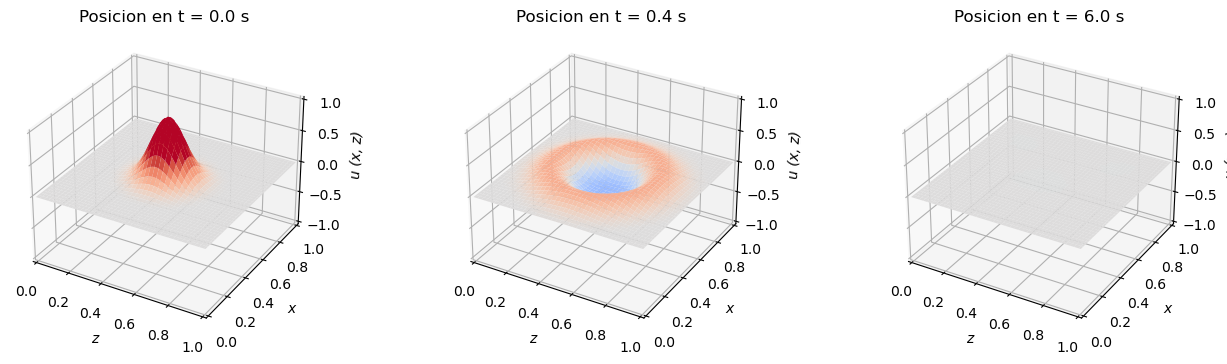

In [4]:
# Soluciones por DF
fig  = plt.figure(figsize = (16, 4))
# snapshot 1
ax   = fig.add_subplot(1, 3, 1, projection = "3d")
surf = ax.plot_surface(x, z, u[:, :, 1], cmap = "coolwarm", linewidth = 0, vmin = -.5, vmax = .5)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Lz)
ax.set_zlim(-1, 1)
ax.set_xlabel("z", fontstyle = "italic")
ax.set_ylabel("x", fontstyle = "italic")
ax.set_zlabel("u (x, z)", fontstyle = "italic")
ax.set_title(f"Posicion en t = {int(10*t[1])/10} s")
# snapshot 2
n=12
ax   = fig.add_subplot(1, 3, 2, projection = "3d")
surf = ax.plot_surface(x, z, u[:, :, int(h/n)], cmap = "coolwarm", linewidth = 0, vmin = -.5, vmax = .5)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Lz)
ax.set_zlim(-1, 1)
ax.set_xlabel("z", fontstyle = "italic")
ax.set_ylabel("x", fontstyle = "italic")
ax.set_zlabel("u (x, z)", fontstyle = "italic")
ax.set_title(f"Posicion en t = {int(10*t[int(h/n)])/10} s")
# snapshot 3
ax   = fig.add_subplot(1, 3, 3, projection = "3d")
surf = ax.plot_surface(x, z, u[:, :, -1], cmap = "coolwarm", linewidth = 0, vmin = -.5, vmax = .5)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Lz)
ax.set_zlim(-1, 1)
ax.set_xlabel("z", fontstyle = "italic")
ax.set_ylabel("x", fontstyle = "italic")
ax.set_zlabel("u (x, z)", fontstyle = "italic")
ax.set_title(f"Posicion en t = {int(10*t[-1])/10} s")
plt.show()

## Animación de la propagación de la onda

La siguiente celda genera una animación que muestra la evolución temporal de la solución. Esto nos permite visualizar de manera dinámica cómo se propaga la onda desde su punto de origen, cómo interactúa con las fronteras y cómo se disipa con el tiempo.

La animación se guarda como un archivo GIF para su posterior visualización e inclusión en la presentación.

In [ ]:
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')

def animate(i):
    ax.clear()
    ax.plot_surface(x, z, u[:,:,i], cmap = "coolwarm", linewidth = 0, vmin = -.5, vmax = .5)
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Lz)
    ax.set_zlim(-1, 1)
    ax.set_xlabel("z", fontstyle = "italic")
    ax.set_ylabel("x", fontstyle = "italic")
    ax.set_zlabel("u (x, z)", fontstyle = "italic")
    ax.set_title(f"Posicion en t = {int(10*t[i])/10} s")

anim = FuncAnimation(fig, animate, range(1,len(t)-1), interval=8)
anim.save('Onda 2D S Homogeneo.gif')
anim

## Generación y almacenamiento de sismogramas sintéticos

En esta sección, generamos sismogramas sintéticos a partir de la solución obtenida. Los sismogramas representan el registro del movimiento del suelo en puntos específicos de la superficie a lo largo del tiempo.

Generamos 20 sismogramas en puntos equidistantes a lo largo de la superficie. Estos datos se utilizarán posteriormente para entrenar a la red neuronal físicamente informada (PINN).

Los sismogramas se guardan en archivos individuales para su fácil acceso y uso en el entrenamiento de la PINN.

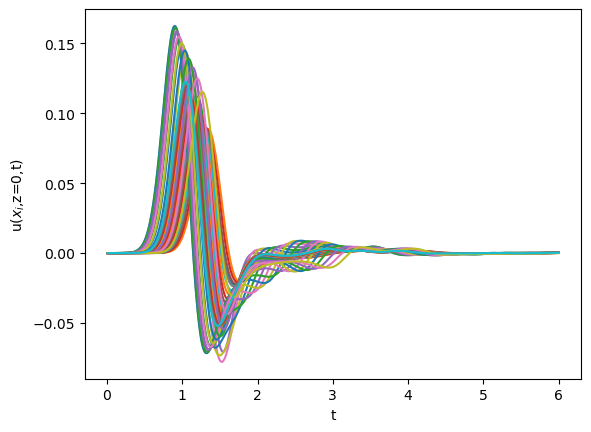

In [5]:
# Guardar la solución en ciertos n puntos de la superficie separados por 50 metros
n=20
l=1
for i in range(20):
    T=t.reshape((len(t),1))
    U=[x[0,int((0.025+0.050*i)/(x[0,1]-x[0,0]))]]+list(u[int((0.025+0.050*i)/(x[0,1]-x[0,0])),0,:])
    plt.plot(T[1:],list(u[2+4*i,0,:]), label=f"Sismograma en x={x[int((0.025+0.050*i)/(x[0,1]-x[0,0]))]} km")
    np.savez(f"../Código Final/Datasets_Sism/x_{l}", t=T, u=U)
    plt.plot(T[1:],list(u[0,int(i),:]), label=f"Sismograma en x={x[int(i)]} km")
    plt.xlabel('t')
    plt.ylabel('u($x_i$,z=0,t)')
    l=l+1 # Etiqueta

## Visualización de sismogramas

En esta sección final, cargamos los sismogramas generados y los visualizamos en un solo gráfico. Esta representación muestra el movimiento vertical del suelo en función del tiempo para diferentes posiciones a lo largo de la superficie.

Esta visualización nos permite observar:
1. La llegada de las ondas a diferentes distancias de la fuente
2. La forma de las ondas registradas en cada punto

Estos sismogramas servirán para entrenar y evaluar el desempeño de la PINN en la inversión de datos sísmicos.

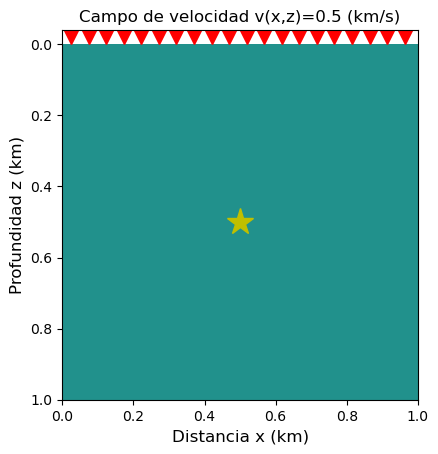

In [6]:
# Se cargan los datos de los sismogramas
n=20 # Se define la misma n que cuando se generaron los datos 
x_sism=[]
u_sism=[]
for i in range(n):
    data = np.load(f"../Código Final/Datasets_Sism/x_{i+1}.npz")
    t_sism = data["t"][1:]
    x_sism.append(data["u"][0])
    u_sism.append(data["u"][1:]) 

    
v1=0.5
C2=np.ones((Nx+1,Nz+1))*v1

fig5 = plt.figure(9)
ax = fig5.subplots()
cs=ax.contourf(x, z, C2)
plt.plot(x_sism,np.zeros(len(x_sism))-0.02,"rv",markersize=10)
plt.plot(Lz/2,Lx/2,"y*",markersize=20)
ax.set_title('Campo de velocidad v(x,z)=0.5 (km/s)',fontsize=12)
ax.set(xlim=(0, Lx), ylim=(-0.04, Lz))
ax.invert_yaxis()
ax.set_xlabel(r'Distancia x (km)', fontsize=12)
ax.set_ylabel(r'Profundidad z (km)', fontsize=12)
ax.set_aspect('equal', adjustable='box')
plt.savefig('Campo vel.png')

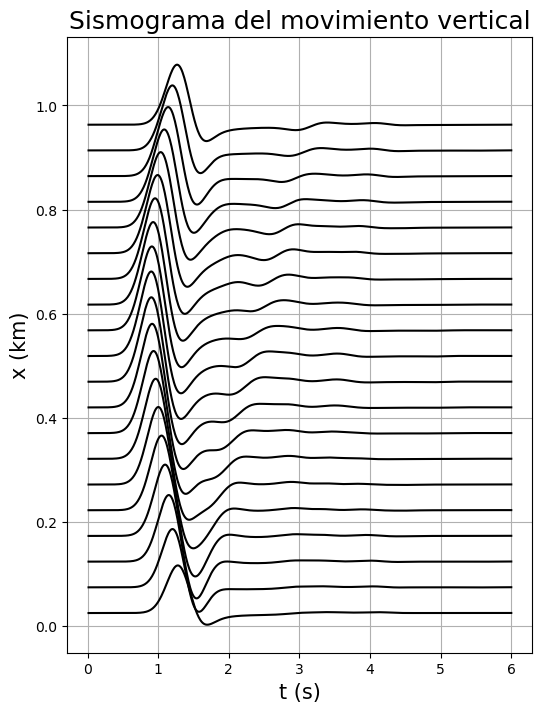

In [7]:
def plot_sismograms(x_0, i, z_0, t_max):
    """
    Grafica la solución obtenida por diferencias finitas para una coordenada espacial dada u(x_0, z_0, t).
    hasta el tiempo t_max

    Args:
        x_0: Valores de x_sism (posiciones de los receptores)
        i: Selección de uno de los receptores
        z_0: Valor fijo de z.
        t_max: El tiempo máximo (en segundos) para evaluar la solución (p.ej. 6 segundos).
    """
    plt.plot(t_sism,u_sism[i]+np.full_like(u_sism[i], x_0[i]),"k-")
    
fig = plt.figure(figsize=(6, 8))
plt.xlabel('t (s)', fontsize=15)
plt.ylabel('x (km)', fontsize=15)
plt.title("Sismograma del movimiento vertical", fontsize=18)
plt.grid(True)
n=20
for i in range(n):
    plot_sismograms(x_0=x_sism, i=i, z_0=0.0, t_max=6)

plt.savefig("Sismograms_DF")
plt.show()